# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import glob

In [194]:
# Load array
x_train = np.load('driven_damped_pendulum_data_train.npy')
x_val = np.load('driven_damped_pendulum_data_valid.npy')
x_test = np.load('driven_damped_pendulum_data_test.npy')

kappas_tr, betas_tr, As_tr, omegas_tr = np.loadtxt('driven_damped_pendulum_data_params_train.dat', unpack=True)
kappas_va, betas_va, As_va, omegas_va = np.loadtxt('driven_damped_pendulum_data_params_valid.dat', unpack=True)
kappas_te, betas_te, As_te, omegas_te = np.loadtxt('driven_damped_pendulum_data_params_test.dat', unpack=True)

In [195]:
def sampling(args):
    z_mean, z_log_sigma, dim = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dim),
                             mean=0, stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# Neural Network

In [272]:
num_hidden_layers = 4
encoding_dim = 5
input_dim = x_train.shape[1]
hidden_dim = 100
batch_size = 1024
epochs = 200
learning_rate = 0.001
regul=0.00
regul2=0.0001

factor = 0.25
patience = 50
min_lr = 0.000001
verbose = 1

In [273]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=factor,
                                                 patience=patience, 
                                                 min_lr=min_lr, 
                                                 verbose=verbose
                                                )

In [274]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=verbose
    )

In [275]:
early_stopping_callback = EarlyStopping(
    patience=patience,
    monitor='val_loss',
    mode='min',
    verbose=verbose
)

## Autoencoder

In [276]:
encoder_input = keras.Input(shape=(input_dim,))

#encoder 
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(encoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
z_mean = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)
z_log_sigma = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)

z = layers.Lambda(sampling)([z_mean, z_log_sigma, encoding_dim])

decoder_input = keras.Input(shape=(encoding_dim,)) 

#decoder
x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(decoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
decoded = layers.Dense(input_dim, activation='linear')(x)

encoder = keras.Model(encoder_input, [z_mean, z_log_sigma, z])
decoder = keras.Model(decoder_input, decoded)

autoencoder = keras.Model(encoder_input, decoder(encoder(encoder_input)[2]))

In [277]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='mse', metrics=['mse'])

## training the model

In [278]:
fitting_output = autoencoder.fit(x_train, x_train, 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 #shuffle=True,
                                 validation_data=(x_val, x_val),
                                 callbacks=[reduce_lr, model_checkpoint_callback, early_stopping_callback])

Epoch 1/200
13/14 [==========================>...] - ETA: 0s - loss: 0.2436 - mse: 0.2383
Epoch 1: val_loss improved from inf to 0.20633, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 7s 98ms/step - loss: 0.2421 - mse: 0.2367 - val_loss: 0.2063 - val_mse: 0.2005 - lr: 0.0010
Epoch 2/200
13/14 [==========================>...] - ETA: 0s - loss: 0.2069 - mse: 0.2022
Epoch 2: val_loss improved from 0.20633 to 0.19785, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 49ms/step - loss: 0.2066 - mse: 0.2020 - val_loss: 0.1978 - val_mse: 0.1942 - lr: 0.0010
Epoch 3/200
13/14 [==========================>...] - ETA: 0s - loss: 0.2020 - mse: 0.1987
Epoch 3: val_loss improved from 0.19785 to 0.19602, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 50ms/step - loss: 0.2025 - mse: 0.1991 - val_loss: 0.1960 - val_mse: 0.1932 - lr: 0.0010
Epoch 4/200
13/14 [================

13/14 [==========================>...] - ETA: 0s - loss: 0.0175 - mse: 0.0131
Epoch 51: val_loss improved from 0.01787 to 0.01771, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 51ms/step - loss: 0.0175 - mse: 0.0131 - val_loss: 0.0177 - val_mse: 0.0135 - lr: 0.0010
Epoch 52/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0171 - mse: 0.0128
Epoch 52: val_loss improved from 0.01771 to 0.01720, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 50ms/step - loss: 0.0171 - mse: 0.0129 - val_loss: 0.0172 - val_mse: 0.0130 - lr: 0.0010
Epoch 53/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0168 - mse: 0.0125
Epoch 53: val_loss improved from 0.01720 to 0.01700, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 52ms/step - loss: 0.0168 - mse: 0.0125 - val_loss: 0.0170 - val_mse: 0.0128 - lr: 0.0010
Epoch 54/200
13/14 [==================

14/14 [==============================] - 1s 60ms/step - loss: 0.0099 - mse: 0.0065 - val_loss: 0.0103 - val_mse: 0.0069 - lr: 0.0010
Epoch 78/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0098 - mse: 0.0064
Epoch 78: val_loss improved from 0.01033 to 0.01023, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 48ms/step - loss: 0.0098 - mse: 0.0064 - val_loss: 0.0102 - val_mse: 0.0069 - lr: 0.0010
Epoch 79/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0097 - mse: 0.0063
Epoch 79: val_loss improved from 0.01023 to 0.01005, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 48ms/step - loss: 0.0097 - mse: 0.0063 - val_loss: 0.0100 - val_mse: 0.0067 - lr: 0.0010
Epoch 80/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0096 - mse: 0.0062
Epoch 80: val_loss did not improve from 0.01005
14/14 [==============================] - 0s 35ms/step - loss: 0.0095 - mse: 0.

Epoch 104/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0070 - mse: 0.0041
Epoch 104: val_loss did not improve from 0.00743
14/14 [==============================] - 1s 39ms/step - loss: 0.0070 - mse: 0.0041 - val_loss: 0.0075 - val_mse: 0.0046 - lr: 0.0010
Epoch 105/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0068 - mse: 0.0039
Epoch 105: val_loss improved from 0.00743 to 0.00742, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 54ms/step - loss: 0.0068 - mse: 0.0039 - val_loss: 0.0074 - val_mse: 0.0046 - lr: 0.0010
Epoch 106/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0067 - mse: 0.0038
Epoch 106: val_loss improved from 0.00742 to 0.00717, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 52ms/step - loss: 0.0067 - mse: 0.0038 - val_loss: 0.0072 - val_mse: 0.0043 - lr: 0.0010
Epoch 107/200
14/14 [==============================] - ETA: 0s - loss: 0

14/14 [==============================] - 1s 50ms/step - loss: 0.0053 - mse: 0.0027 - val_loss: 0.0058 - val_mse: 0.0034 - lr: 0.0010
Epoch 132/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0052 - mse: 0.0027
Epoch 132: val_loss did not improve from 0.00585
14/14 [==============================] - 1s 37ms/step - loss: 0.0052 - mse: 0.0027 - val_loss: 0.0060 - val_mse: 0.0035 - lr: 0.0010
Epoch 133/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0053 - mse: 0.0028
Epoch 133: val_loss improved from 0.00585 to 0.00583, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 54ms/step - loss: 0.0053 - mse: 0.0028 - val_loss: 0.0058 - val_mse: 0.0034 - lr: 0.0010
Epoch 134/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0052 - mse: 0.0027
Epoch 134: val_loss improved from 0.00583 to 0.00576, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 49ms/step - loss: 0.0052 - m

Epoch 187/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0040 - mse: 0.0019
Epoch 187: val_loss did not improve from 0.00447
14/14 [==============================] - 1s 38ms/step - loss: 0.0040 - mse: 0.0019 - val_loss: 0.0045 - val_mse: 0.0025 - lr: 0.0010
Epoch 188/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0039 - mse: 0.0019
Epoch 188: val_loss improved from 0.00447 to 0.00445, saving model to /tmp/ckpt/checkpoint.weights.h5
14/14 [==============================] - 1s 50ms/step - loss: 0.0039 - mse: 0.0019 - val_loss: 0.0044 - val_mse: 0.0025 - lr: 0.0010
Epoch 189/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0039 - mse: 0.0019
Epoch 189: val_loss did not improve from 0.00445
14/14 [==============================] - 1s 37ms/step - loss: 0.0039 - mse: 0.0019 - val_loss: 0.0045 - val_mse: 0.0025 - lr: 0.0010
Epoch 190/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0040 - mse: 0.0020
Epoch 190: val_loss did not impro

In [279]:
training_history = fitting_output.history

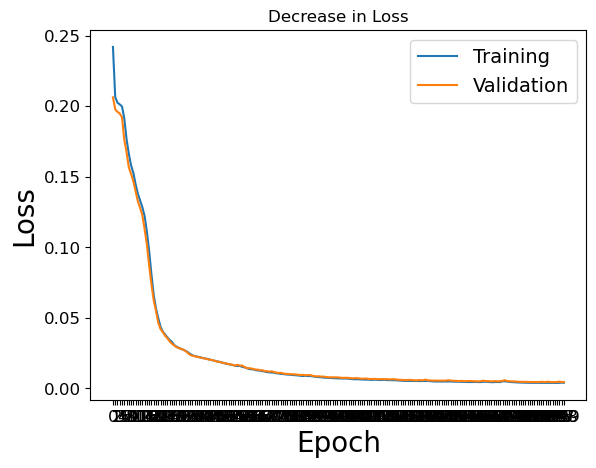

In [280]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.plot(fitting_output.history['loss'], label='Training')
ax.plot(fitting_output.history['val_loss'], label='Validation')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_xticks(np.arange(0, epochs, 1))
#ax.set_ylim(0, 0.3)
plt.show()

## testing the model

In [281]:
# compare autoencoder model to encoder and decoder models

f1 = autoencoder.predict(x_test)
f2 = decoder(encoder(x_test)[2])

63/63 [==============================] - 1s 4ms/step


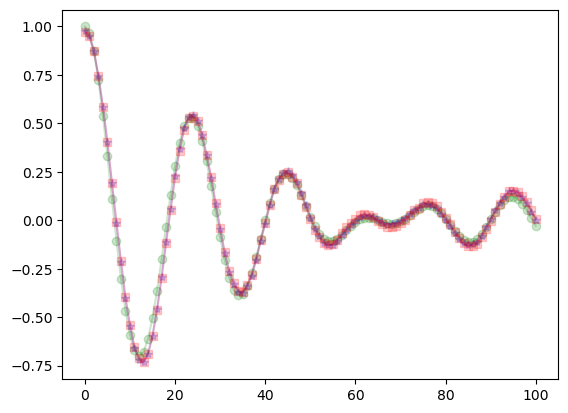

In [282]:
sample = 20

plt.plot(x_test[sample], color='g', marker='o', alpha=0.2)
plt.plot(f1[sample], color='b', marker='*', alpha=0.2)
plt.plot(f2[sample], color='r', marker='s', alpha=0.2)

In [283]:
encoded_data = encoder.predict(x_test)[2]

63/63 [==============================] - 0s 3ms/step


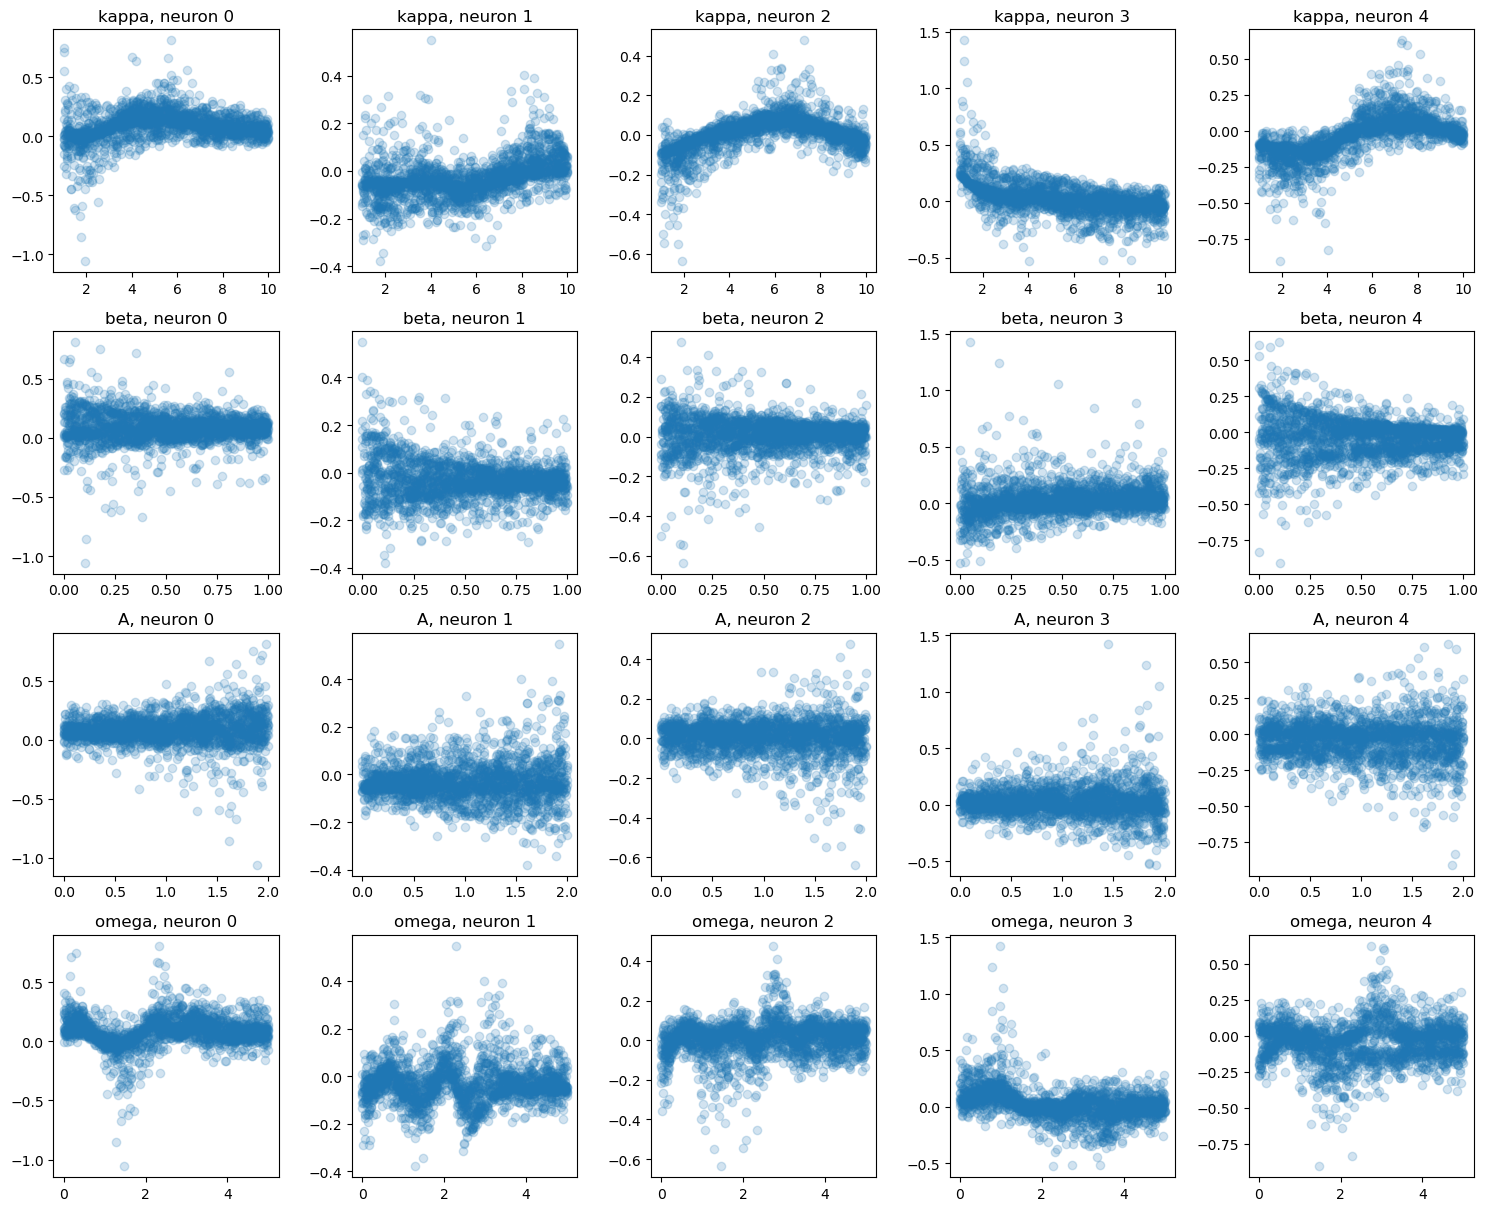

<Figure size 640x480 with 0 Axes>

In [287]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))  # Adjusted figure size for more subplots

# Kappa plots
ax1 = fig.add_subplot(551)
ax1.plot(kappas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax1.set_title('kappa, neuron 0')

ax2 = fig.add_subplot(552)
ax2.plot(kappas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax2.set_title('kappa, neuron 1')

ax3 = fig.add_subplot(553)
ax3.plot(kappas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax3.set_title('kappa, neuron 2')

ax4 = fig.add_subplot(554)
ax4.plot(kappas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax4.set_title('kappa, neuron 3')

ax5 = fig.add_subplot(555)
ax5.plot(kappas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax5.set_title('kappa, neuron 4')

# Beta plots
ax6 = fig.add_subplot(556)
ax6.plot(betas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax6.set_title('beta, neuron 0')

ax7 = fig.add_subplot(557)
ax7.plot(betas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax7.set_title('beta, neuron 1')

ax8 = fig.add_subplot(558)
ax8.plot(betas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax8.set_title('beta, neuron 2')

ax9 = fig.add_subplot(559)
ax9.plot(betas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax9.set_title('beta, neuron 3')

ax10 = fig.add_subplot(5, 5, 10)
ax10.plot(betas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax10.set_title('beta, neuron 4')

# A plots
ax11 = fig.add_subplot(5, 5, 11)
ax11.plot(As_te, encoded_data[:, 0], 'o', alpha=0.2)
ax11.set_title('A, neuron 0')

ax12 = fig.add_subplot(5, 5, 12)
ax12.plot(As_te, encoded_data[:, 1], 'o', alpha=0.2)
ax12.set_title('A, neuron 1')

ax13 = fig.add_subplot(5, 5, 13)
ax13.plot(As_te, encoded_data[:, 2], 'o', alpha=0.2)
ax13.set_title('A, neuron 2')

ax14 = fig.add_subplot(5, 5, 14)
ax14.plot(As_te, encoded_data[:, 3], 'o', alpha=0.2)
ax14.set_title('A, neuron 3')

ax15 = fig.add_subplot(5, 5, 15)
ax15.plot(As_te, encoded_data[:, 4], 'o', alpha=0.2)
ax15.set_title('A, neuron 4')

# Omega plots
ax13 = fig.add_subplot(5, 5, 16)
ax13.plot(omegas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax13.set_title('omega, neuron 0')

ax14 = fig.add_subplot(5, 5, 17)
ax14.plot(omegas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax14.set_title('omega, neuron 1')

ax14 = fig.add_subplot(5, 5, 18)
ax14.plot(omegas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax14.set_title('omega, neuron 2')

ax14 = fig.add_subplot(5, 5, 19)
ax14.plot(omegas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax14.set_title('omega, neuron 3')

ax14 = fig.add_subplot(5, 5, 20)
ax14.plot(omegas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax14.set_title('omega, neuron 4')

# Adjusting layout to prevent overlap
plt.tight_layout()
plt.show()

# If you want to save the figure, uncomment the lines below and specify your save path
graphs_file_path = "VAE_ddp"
plt.savefig(f"{graphs_file_path}.png")
plt.close(fig)